# Ideal Parameter Analysis ($\delta=3$, $\tau=1.25$, $\alpha=2$) ($\delta$ upper bound)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 3
expected_tau = 1.25
expected_alpha = 2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

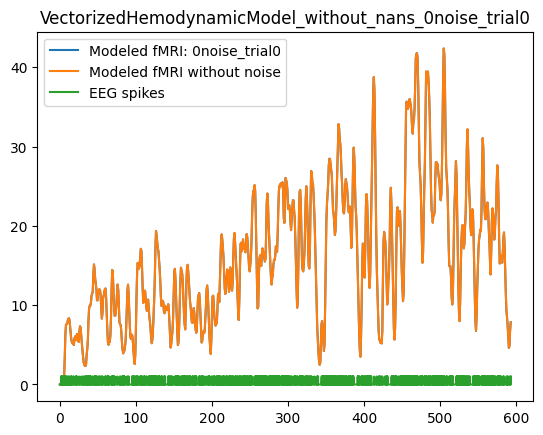

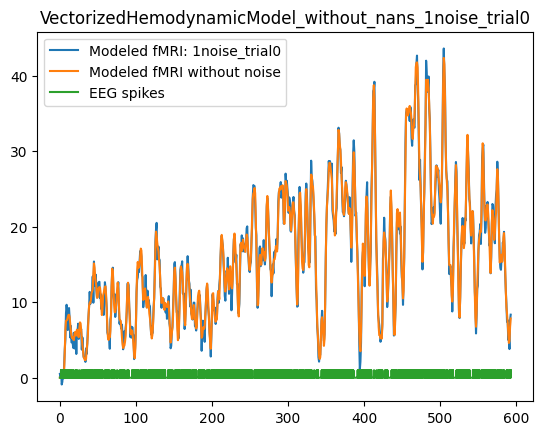

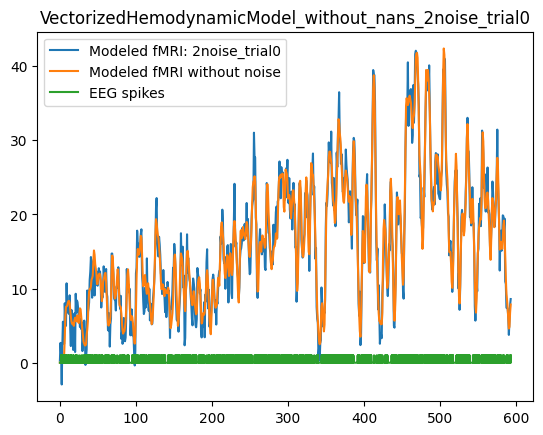

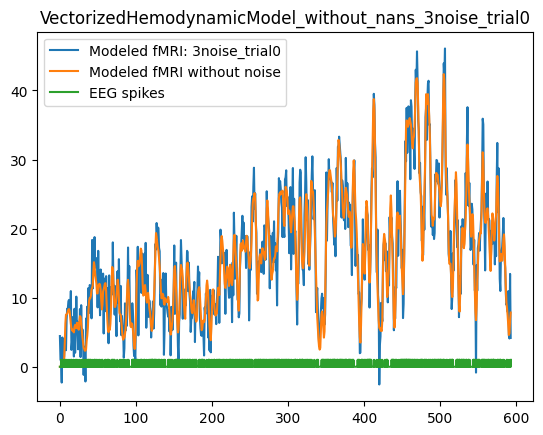

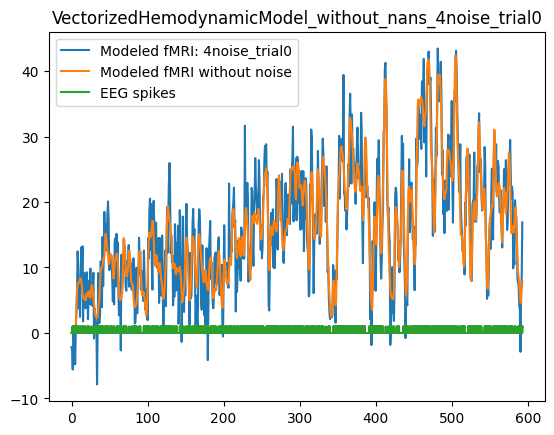

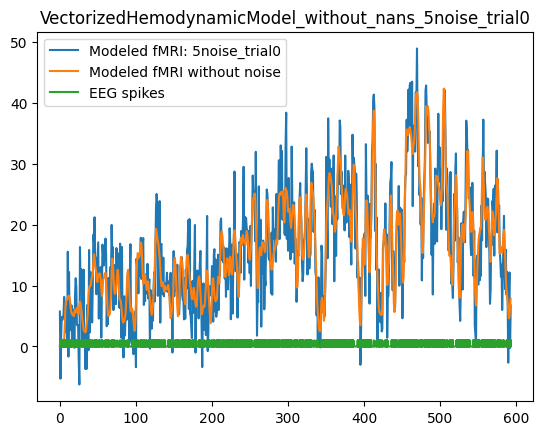

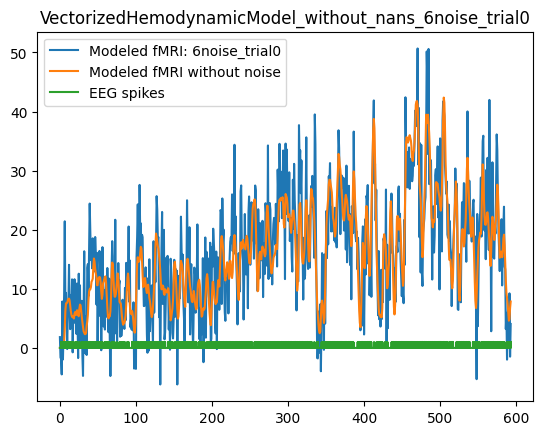

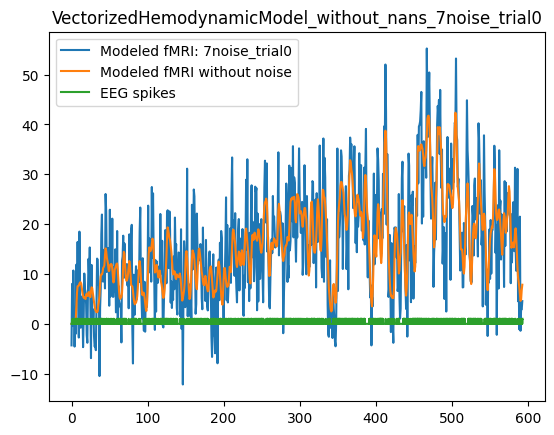

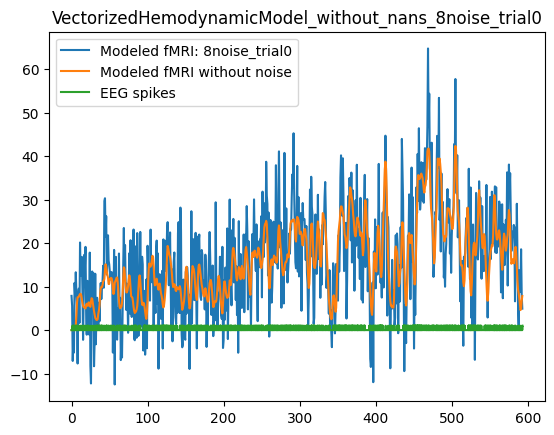

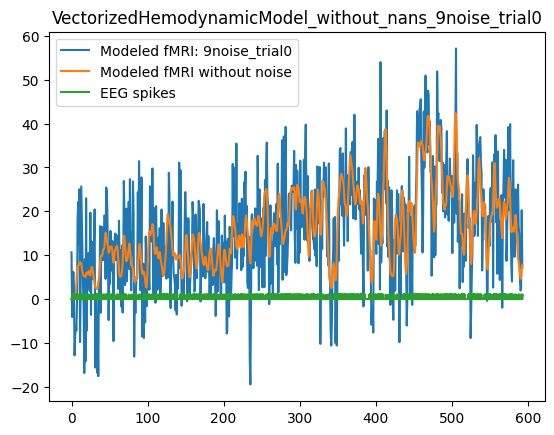

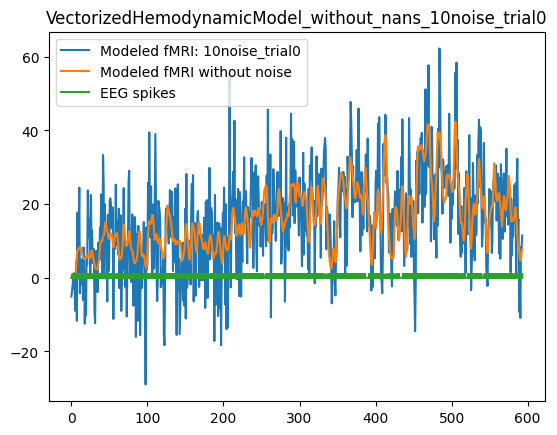

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 3, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=3, tau=1.25, alpha=2


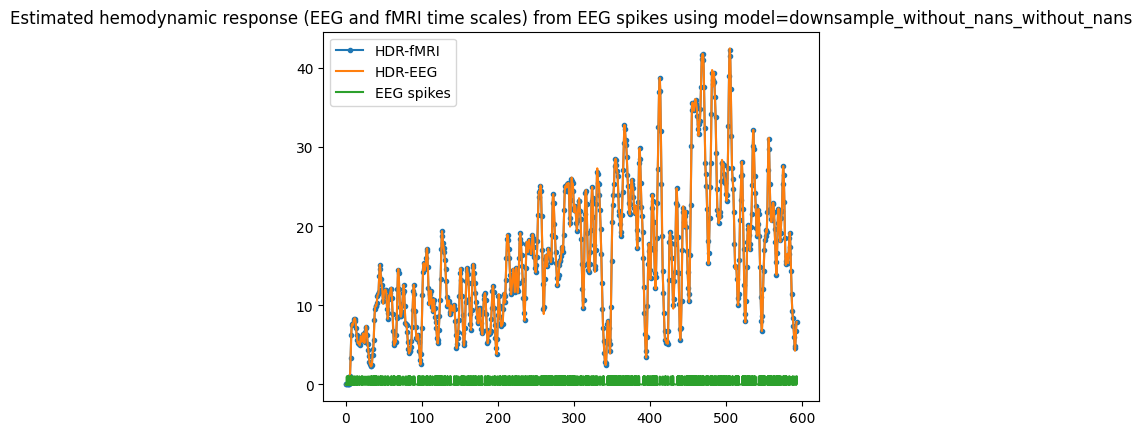

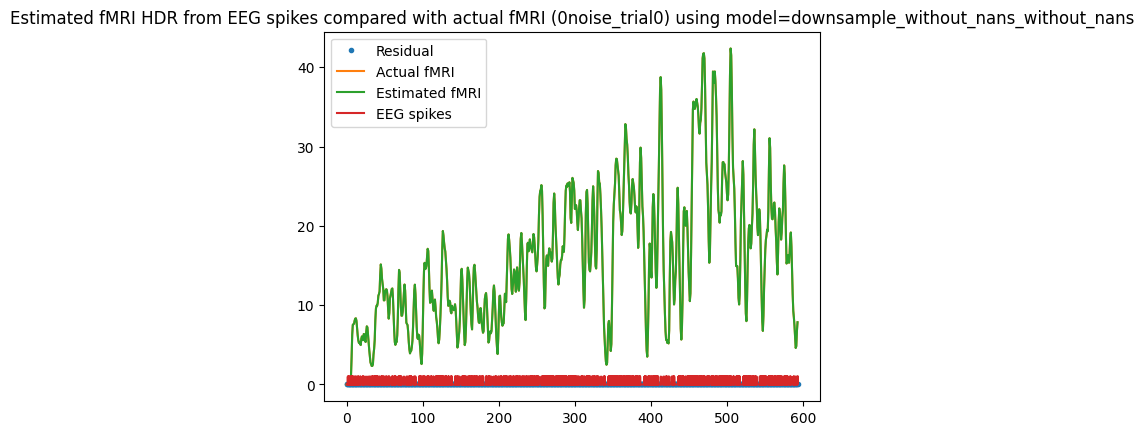

Residual Variance is 0.000000


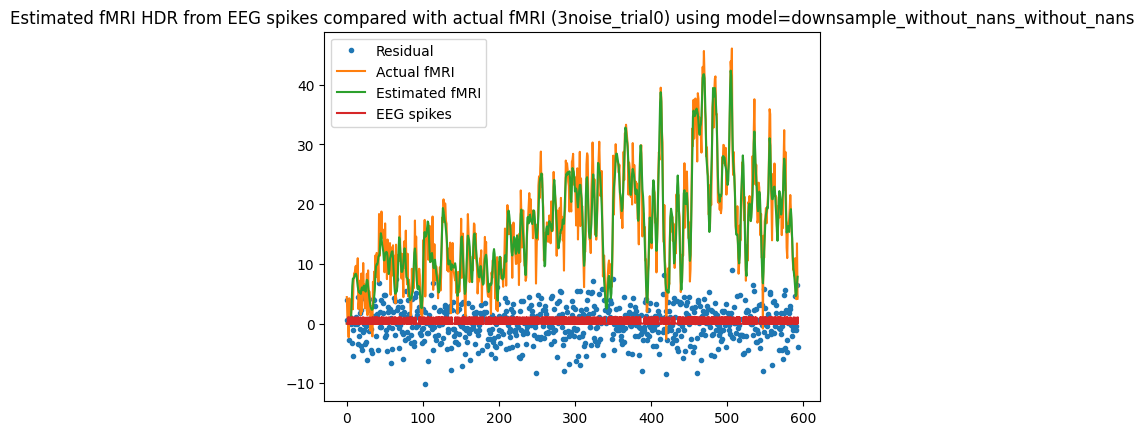

Residual Variance is 8.315955


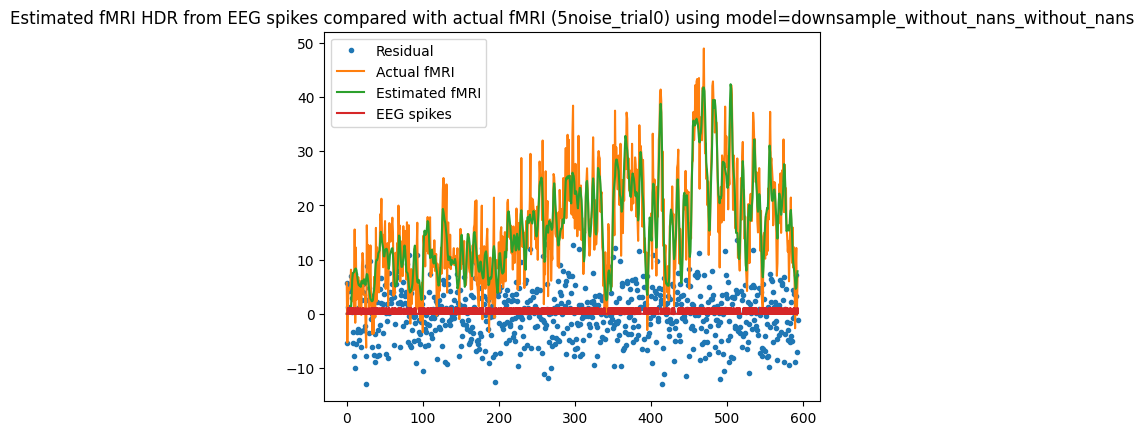

Residual Variance is 23.339478


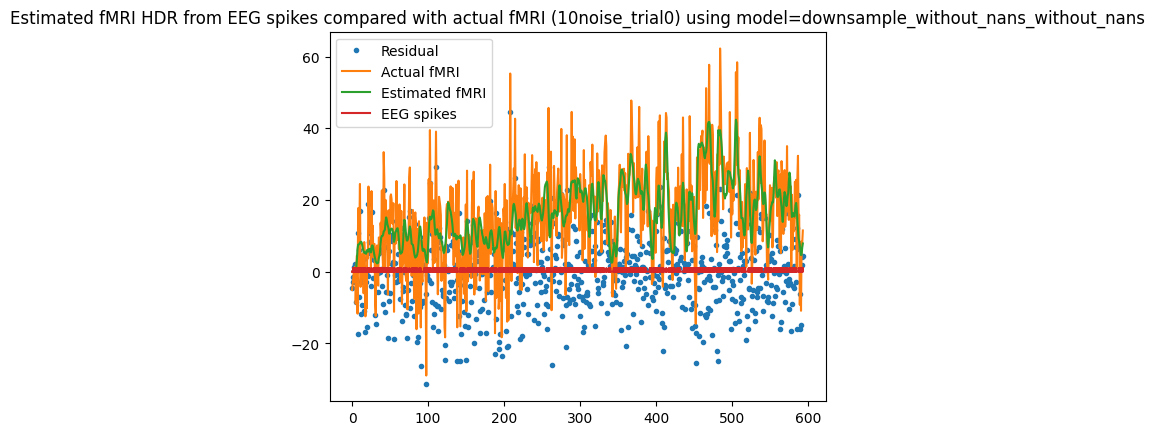

Residual Variance is 101.140064


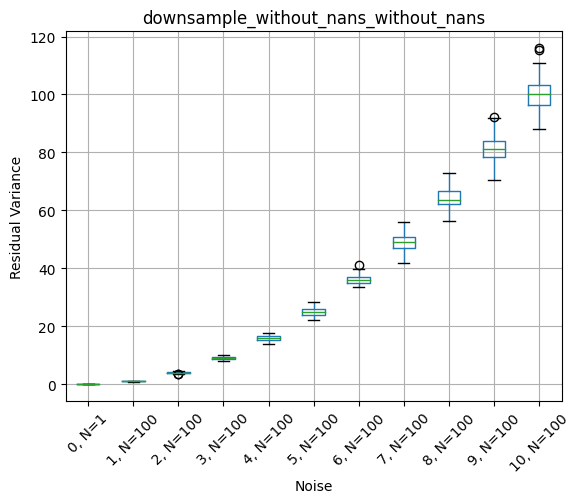

Scoring downsample_without_nans_with_nans delta=3, tau=1.25, alpha=2


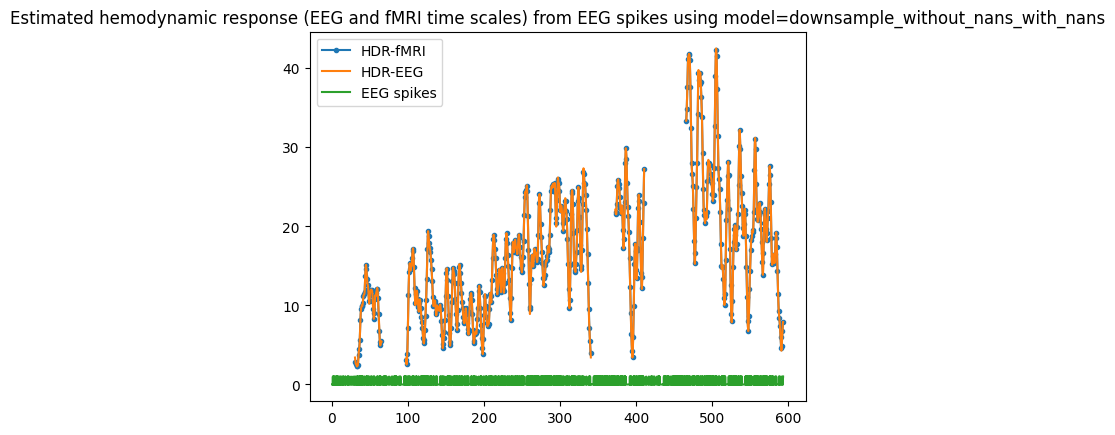

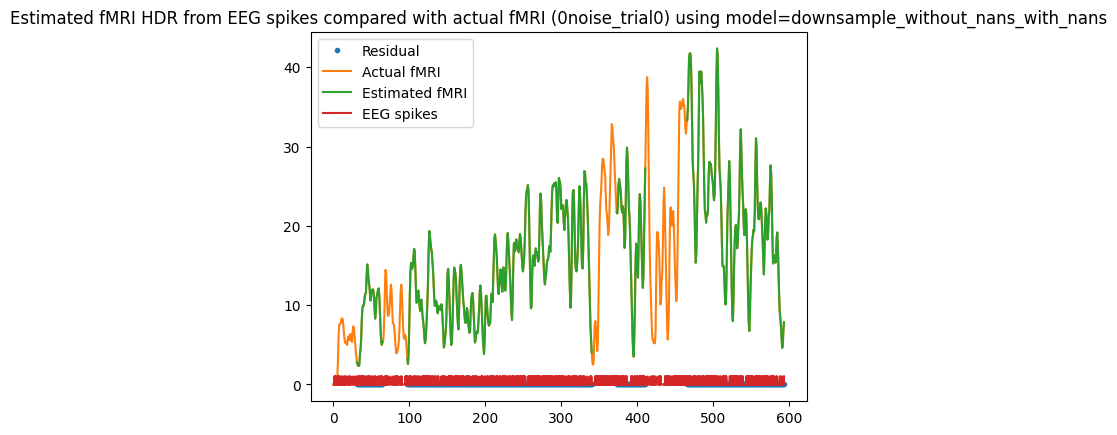

Residual Variance is 0.000000


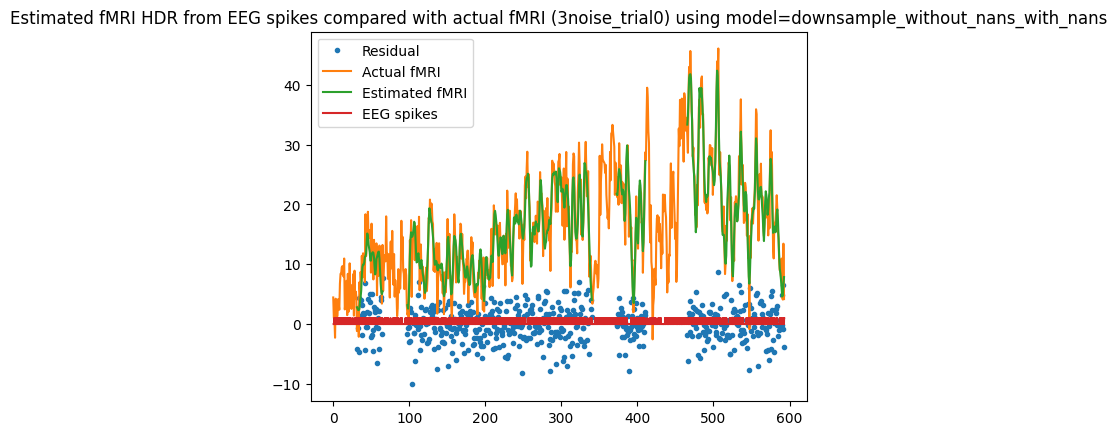

Residual Variance is 8.385178


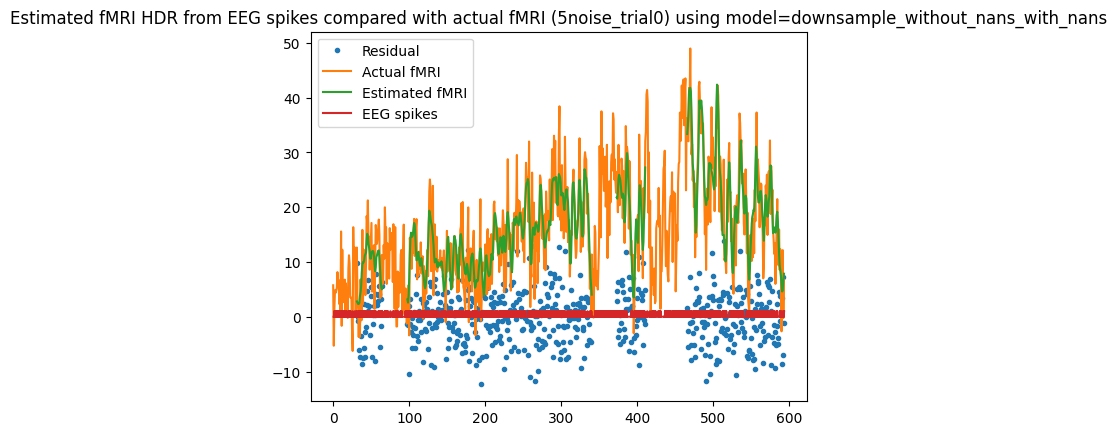

Residual Variance is 22.526045


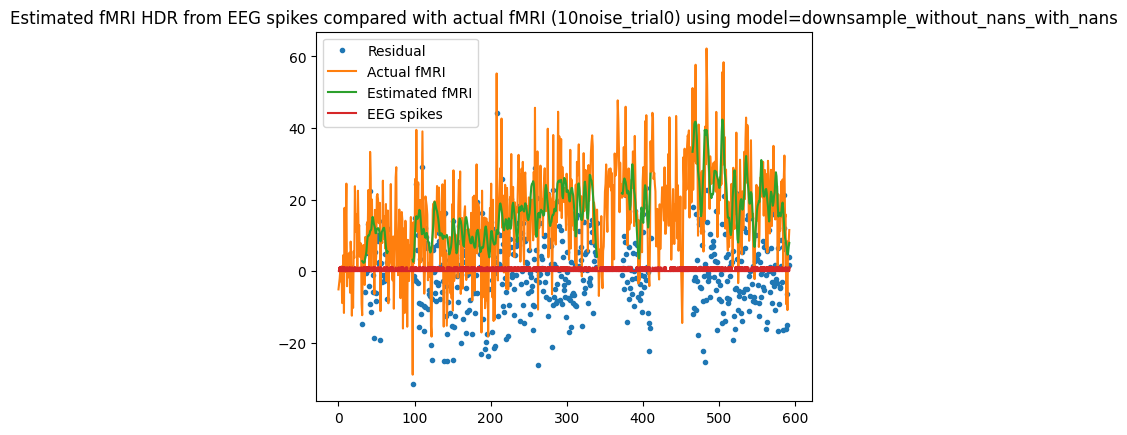

Residual Variance is 106.709125


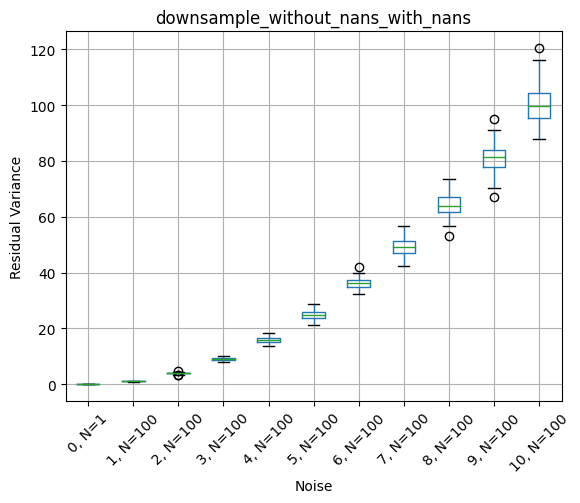

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


Found previously run data. Enter name to reuse or "none" to recalculate.
['effect_of_ideal_params_delta3_tau1.25_alpha2_2023-04-12_11:28.csv']
Default (effect_of_ideal_params_delta3_tau1.25_alpha2_2023-04-12_11:28.csv)

Loading data from effect_of_ideal_params_delta3_tau1.25_alpha2_2023-04-12_11:28.csv...


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

delta   tau  alpha                            model_name  \
0        1.0  0.75   1.75  downsample_without_nans_without_nans   
1        1.0  0.75   1.75     downsample_without_nans_with_nans   
2        1.0  0.75   1.80  downsample_without_nans_without_nans   
3        1.0  0.75   1.80     downsample_without_nans_with_nans   
4        1.0  0.75   1.85  downsample_without_nans_without_nans   
...      ...   ...    ...                                   ...   
18937    3.0  1.75   2.15     downsample_without_nans_with_nans   
18938    3.0  1.75   2.20  downsample_without_nans_without_nans   
18939    3.0  1.75   2.20     downsample_without_nans_with_nans   
18940    3.0  1.75   2.25  downsample_without_nans_without_nans   
18941    3.0  1.75   2.25     downsample_without_nans_with_nans   

       0noise_trial0  1noise_trial0  2noise_trial0  3noise_trial0  \
0          53.040437      53.914519      56.367464      61.182300   
1          47.504062      48.018576      49.819736      55.343855   
2          52.460767      53.332455      55.788169      60.597194   
3          47.043967      47.558617      49.367601      54.859474   
4          51.868553      52.738186      55.196549      60.000922   
...              ...            ...            ...            ...   
18937       6.574477       7.498542      10.016831      16.497768   
18938       7.946021       8.810416      11.556942      17.049451   
18939       7.181733       8.101811      10.610103      17.126971   
18940       8.639315       9.500314      12.251007      17.732418   
18941       7.800533       8.716419      11.214134      17.766510   

       4noise_trial0  5noise_trial0  ...  1noise_trial99  2noise_trial99  \
0          67.771242      80.073973  ...       54.573589       56.595448   
1          61.248259      72.166515  ...       48.841575       50.902445   
2          67.162457      79.503985  ...       53.987364       56.003699   
3          60.801852      71.753739  ...       48.371388       50.441756   
4          66.542952      78.920020  ...       53.388846       55.399294   
...              ...            ...  ...             ...             ...   
18937      19.896150      32.528172  ...        7.608811       11.013221   
18938      23.054358      34.398477  ...        8.819281       12.558464   
18939      20.482169      33.163622  ...        8.217458       11.619731   
18940      23.741510      35.130622  ...        9.506413       13.254974   
18941      21.080562      33.809828  ...        8.837791       12.236386   

       3noise_trial99  4noise_trial99  5noise_trial99  6noise_trial99  \
0           62.453440       69.473359       82.205499       92.012663   
1           57.458459       63.689315       74.664395       86.551499   
2           61.914978       68.884860       81.611702       91.462659   
3           57.044849       63.216578       74.218025       86.137711   
4           61.363169       68.282441       81.003960       90.899285   
...               ...             ...             ...             ...   
18937       15.728161       24.534003       33.717156       43.534825   
18938       17.264435       25.014862       34.650880       44.937589   
18939       16.306506       25.182685       34.402846       44.188746   
18940       17.937772       25.741725       35.439930       45.699577   
18941       16.896427       25.838983       35.098040       44.854290   

       7noise_trial99  8noise_trial99  9noise_trial99  10noise_trial99  
0          100.129313      129.158262      123.355839       156.935447  
1           89.959372      120.190947      123.277574       156.214459  
2           99.523642      128.476817      122.723771       156.252569  
3           89.516769      119.706318      122.773512       155.683638  
4           98.902903      127.782081      122.077665       155.556541  
...               ...             ...             ...              ...  
18937       55.859755       79.054942       84.832495       106.361475  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 2.638594991726356e-28; at
       delta   tau  alpha
18710    3.0  1.25    2.0


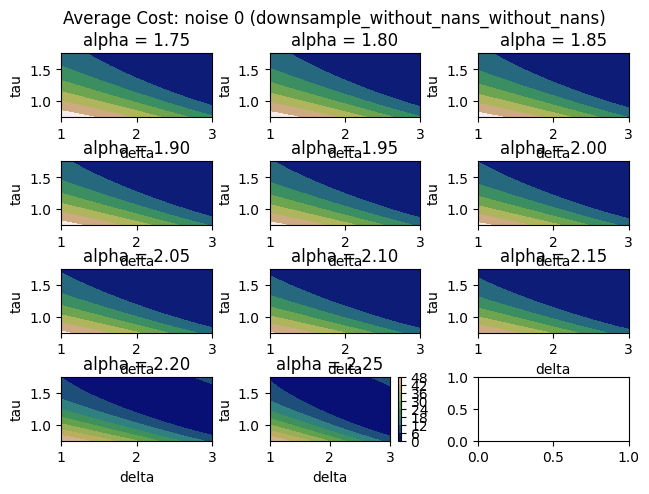

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              53.040437             
2                                              52.460767             
4                                              51.868553             
6                                              51.263914             
8                                              50.646995             
...                                                  ...             
18932                                           5.964581             
18934                                           6.606339             
18936                                           7.267609             
18938                                           7.946021             
18940                                           8.639315             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 3, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    3.0  1.25    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 3, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.366975e-03   2.95  1.20   2.15
1      0         0  2.638595e-28   3.00  1.25   2.00
2      0         0  9.065516e-03   3.00  1.30   1.90

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration          cost  delta   tau  alpha
1      0         0  2.638595e-28    3.0  1.25    2.0
2      0         0  9.065516e-03    3.0  1.30    1.9

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 4.9676161762181795e-28; at
       delta   tau  alpha
18711    3.0  1.25    2.0


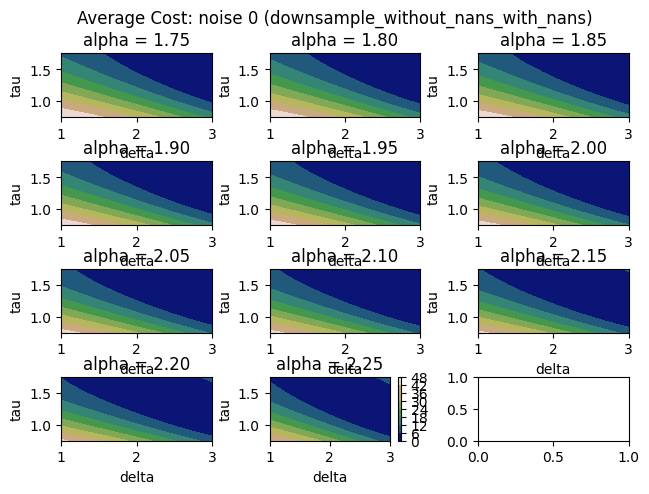

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              47.504062          
3                                              47.043967          
5                                              46.571533          
7                                              46.086758          
9                                              45.589667          
...                                                  ...          
18933                                           5.403505          
18935                                           5.980962          
18937                                           6.574477          
18939                                           7.181733          
18941                                           7.800533          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 3, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    3.0  1.25    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 3, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.325135e-03   2.95  1.20   2.15
1      0         0  4.967616e-28   3.00  1.25   2.00
2      0         0  9.007328e-03   3.00  1.30   1.90

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration          cost  delta   tau  alpha
1      0         0  4.967616e-28    3.0  1.25    2.0
2      0         0  9.007328e-03    3.0  1.30    1.9

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.0100491751550598; at
       delta   tau  alpha
18710    3.0  1.25    2.0


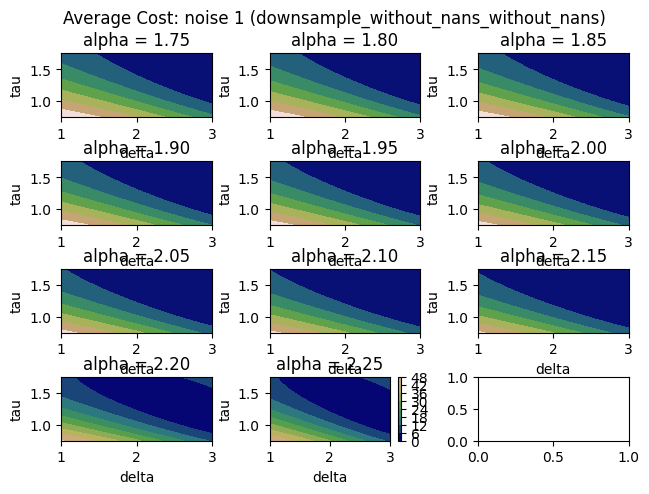

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.022222879882184; at
       delta   tau  alpha
18710    3.0  1.25    2.0


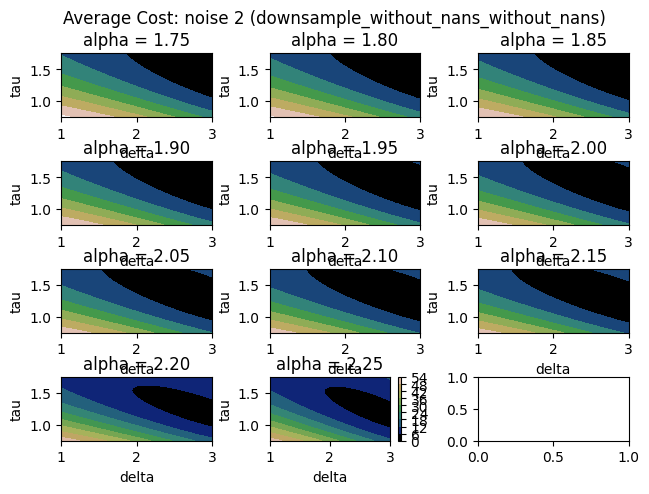

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.966410622320257; at
       delta   tau  alpha
18710    3.0  1.25    2.0


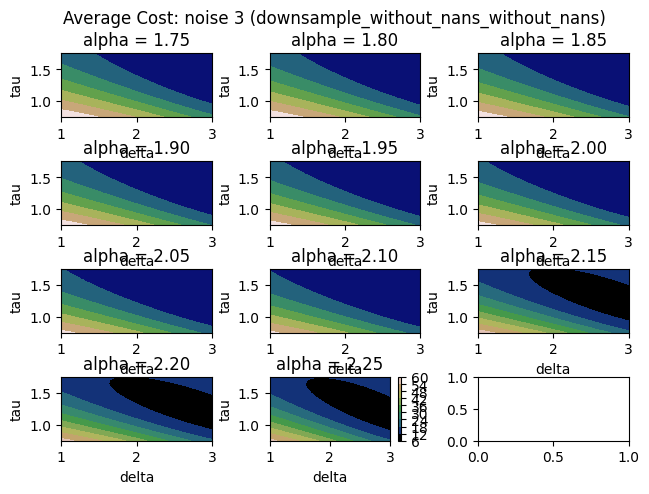

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.057169768431898; at
       delta   tau  alpha
18710    3.0  1.25    2.0


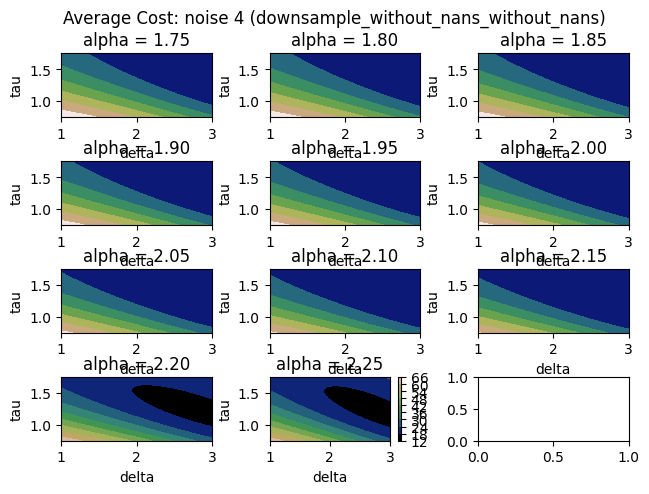

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.08436798982332; at
       delta   tau  alpha
18710    3.0  1.25    2.0


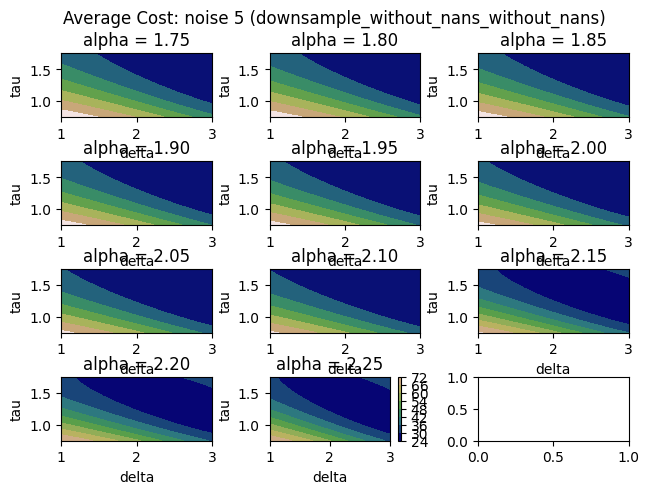

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.19815430185838; at
       delta   tau  alpha
18710    3.0  1.25    2.0


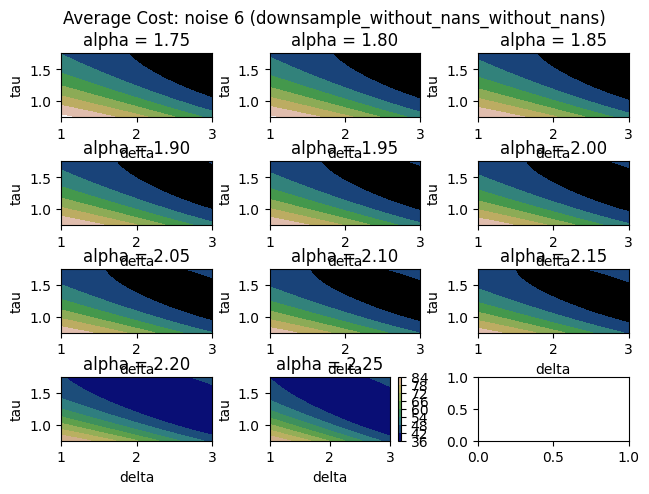

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.295299396039766; at
       delta   tau  alpha
18710    3.0  1.25    2.0


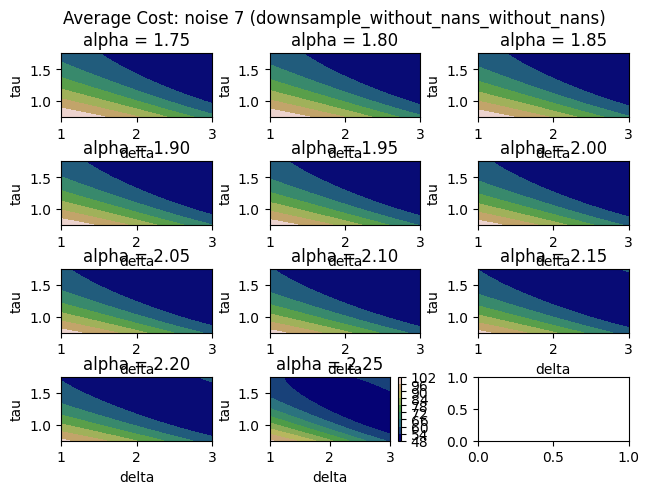

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.06943019092232; at
       delta   tau  alpha
18250   2.95  1.25   2.05


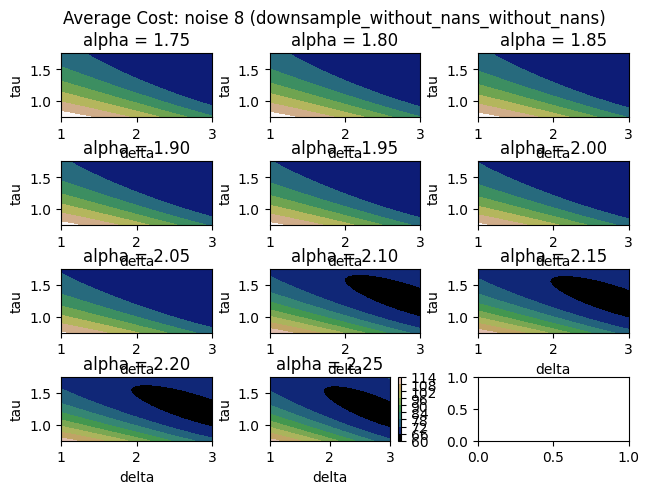

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.90999276497078; at
       delta   tau  alpha
18710    3.0  1.25    2.0


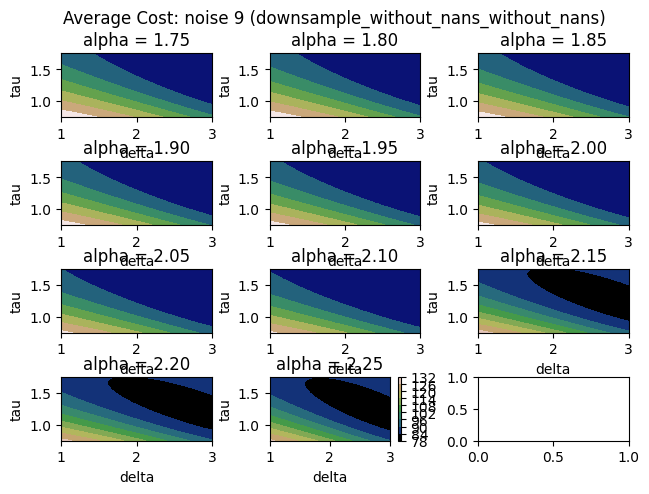

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 100.83445150902745; at
       delta  tau  alpha
17772    2.9  1.2    2.2


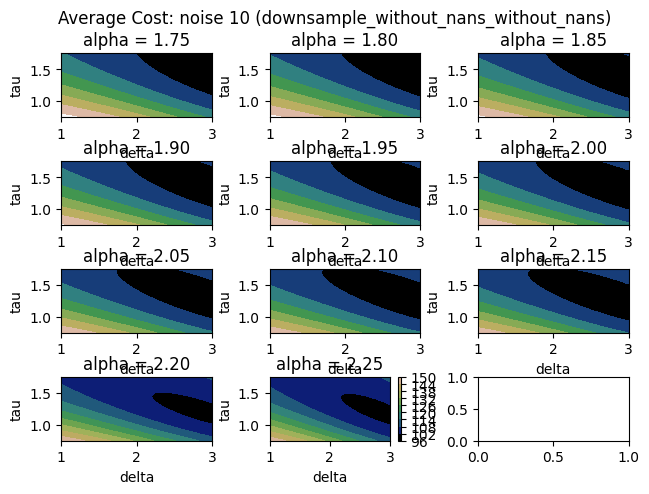

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

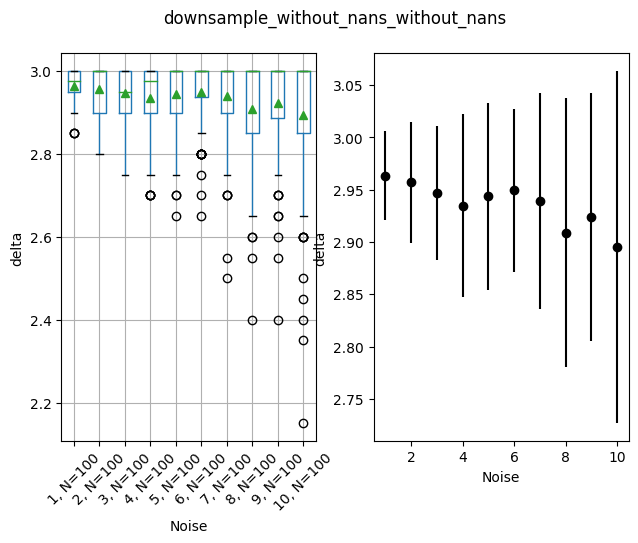

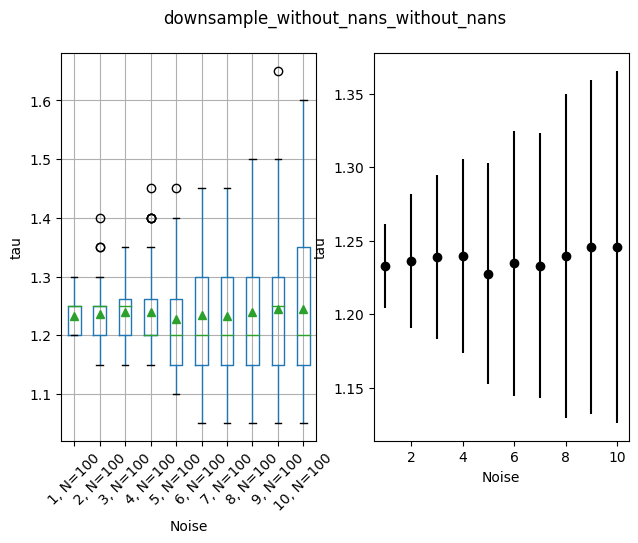

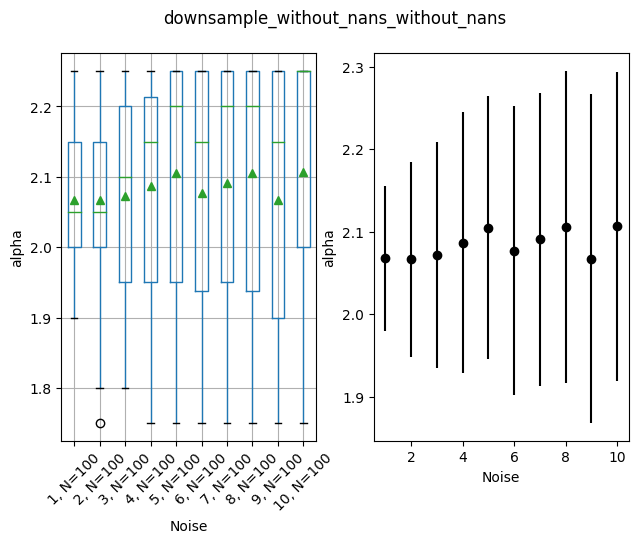

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.0072226804329558; at
       delta   tau  alpha
18711    3.0  1.25    2.0


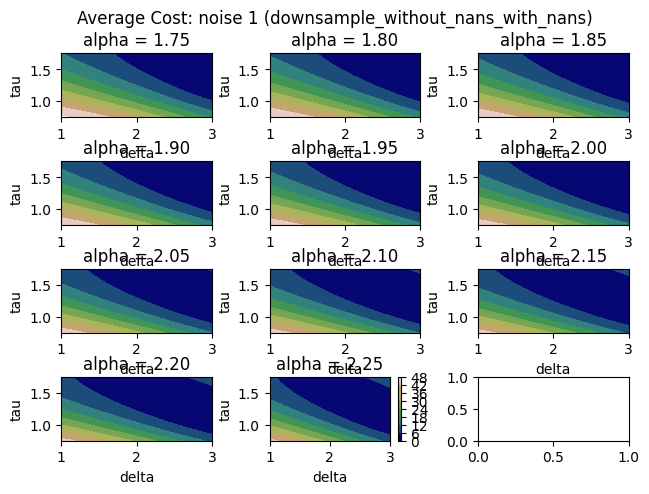

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.026661219959762; at
       delta   tau  alpha
18711    3.0  1.25    2.0


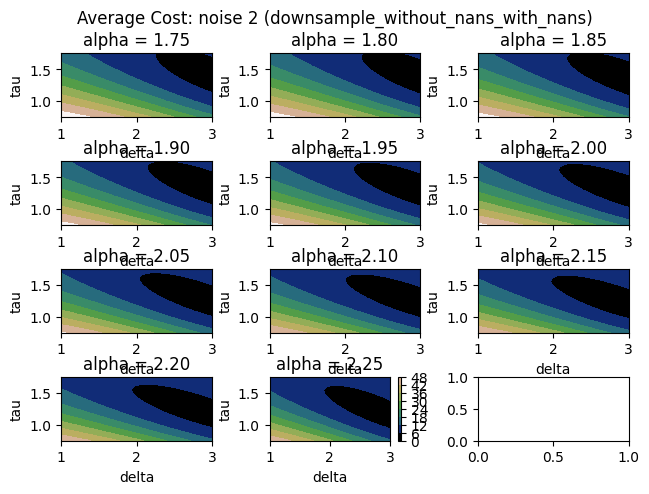

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.946666016033822; at
       delta   tau  alpha
18711    3.0  1.25    2.0


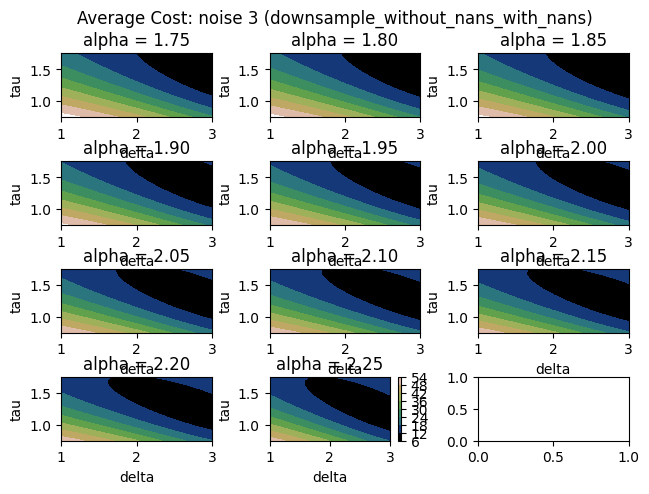

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.038620620824755; at
       delta   tau  alpha
18251   2.95  1.25   2.05


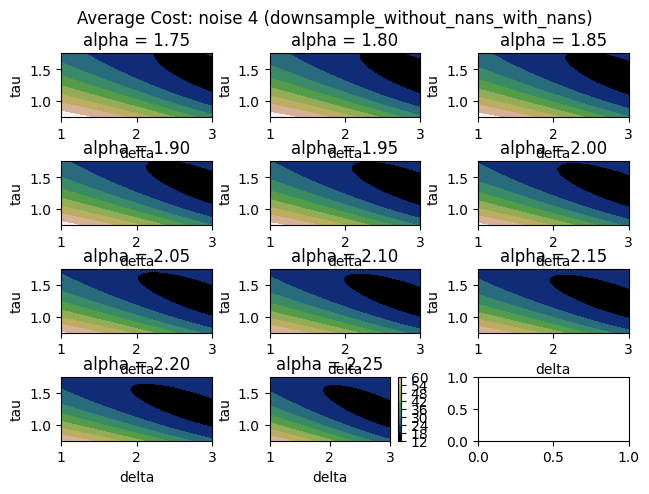

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.223926907182122; at
       delta  tau  alpha
18233   2.95  1.2   2.15


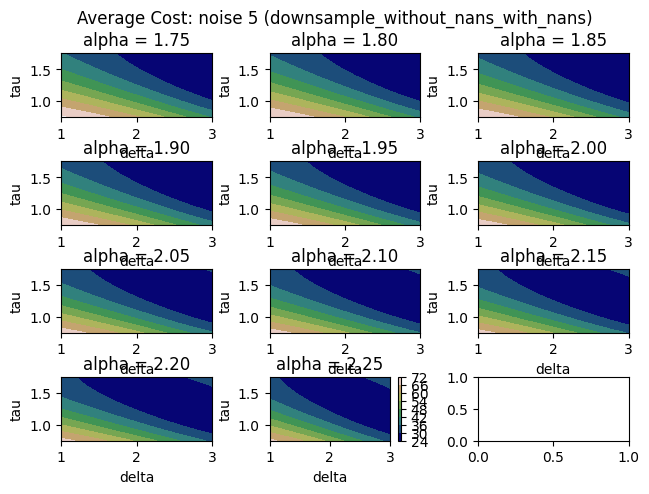

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.27708195114497; at
       delta   tau  alpha
18711    3.0  1.25    2.0


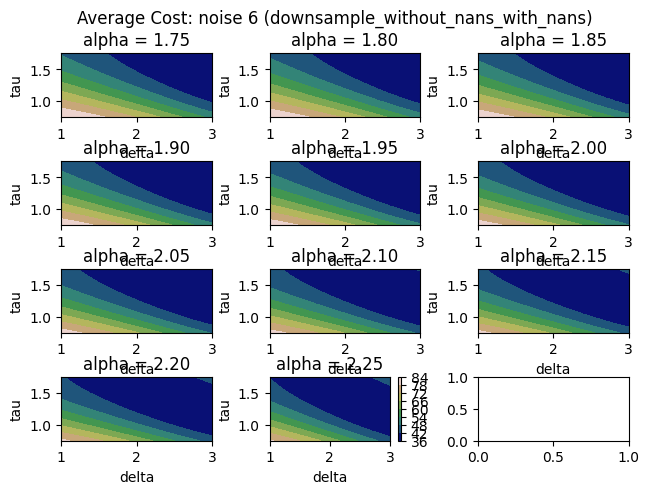

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 49.052405750887665; at
       delta  tau  alpha
18233   2.95  1.2   2.15


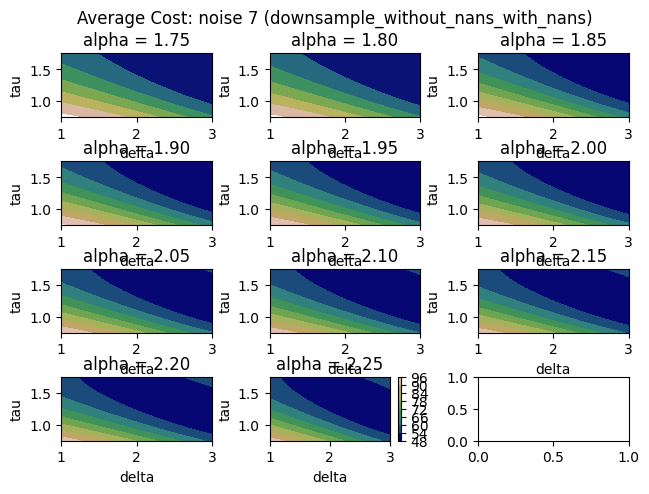

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.15076081454933; at
       delta   tau  alpha
18711    3.0  1.25    2.0


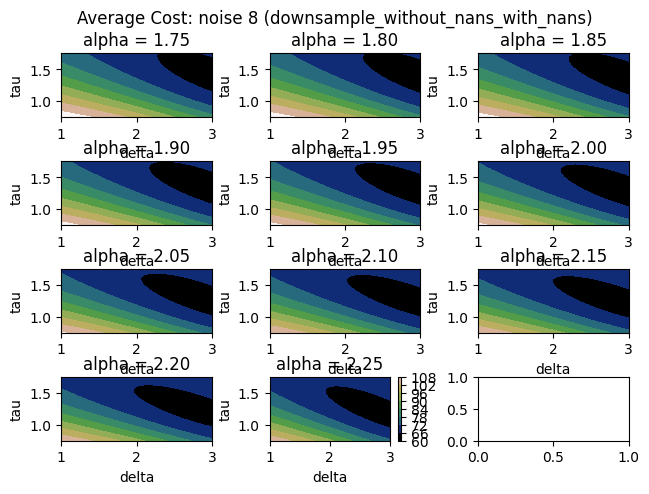

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.06888591121067; at
       delta   tau  alpha
18711    3.0  1.25    2.0


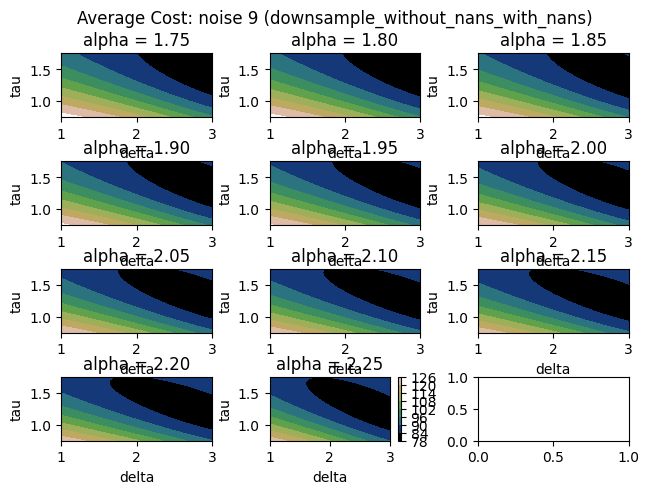

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 100.88505011942817; at
       delta  tau  alpha
17773    2.9  1.2    2.2


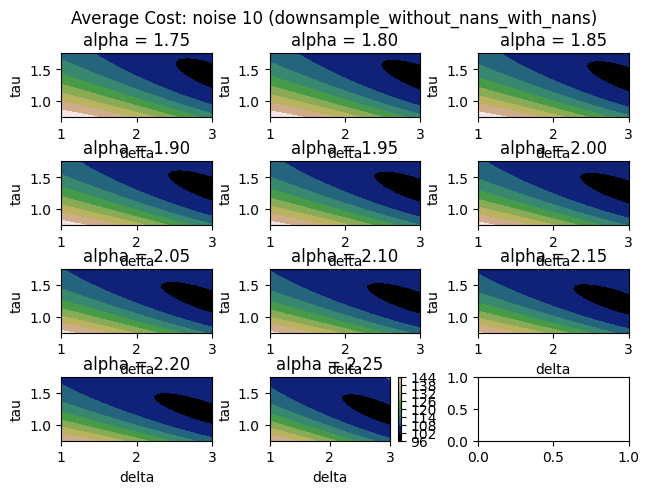

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


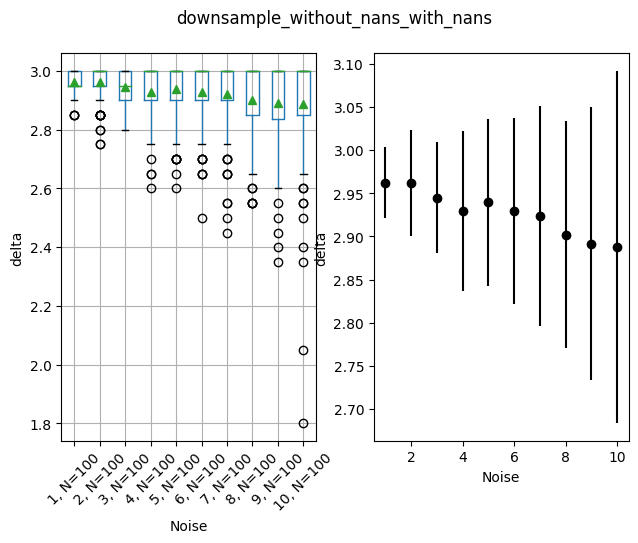

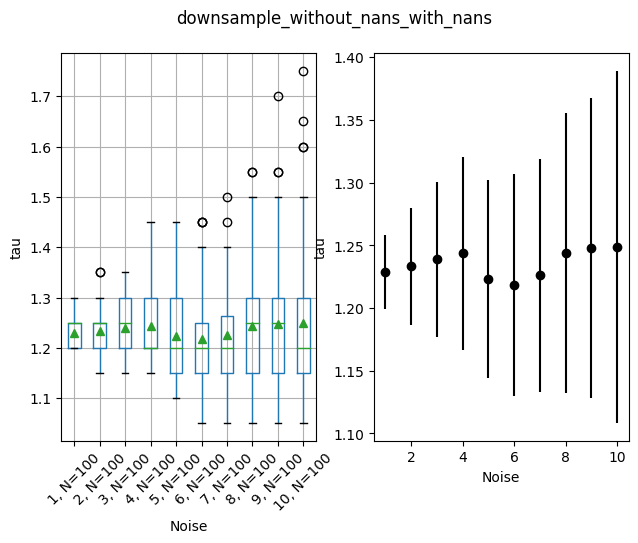

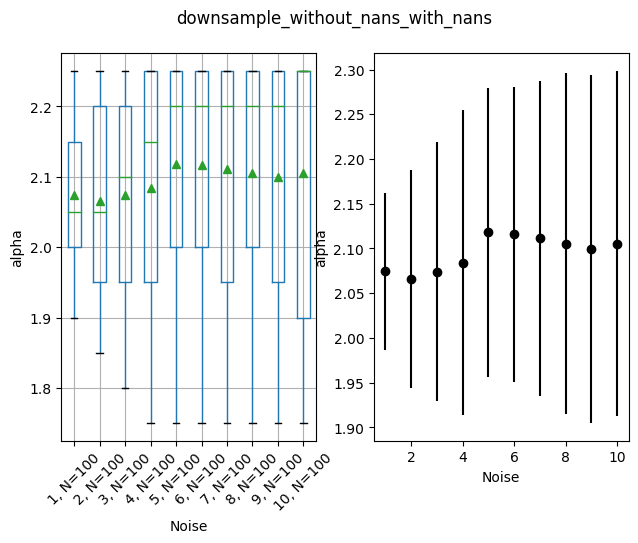

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost  delta   tau  alpha
0         1        80    1.021867   2.80  1.20   2.25
1         1         7    1.009749   2.85  1.20   2.20
2         1        51    0.995777   2.85  1.20   2.20
3         1         0    1.051715   2.85  1.20   2.25
4         1         8    0.991969   2.85  1.20   2.25
...     ...       ...         ...    ...   ...    ...
2391     10        52  115.346445   3.00  1.40   1.95
2392     10        63  102.188085   3.00  1.45   1.75
2393     10        27   94.197461   3.00  1.45   1.90
2394     10        40  101.664837   3.00  1.50   1.75
2395     10        27   94.206919   3.00  1.50   1.80

[2396 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  2.97  0.540389  2.0  3.0  3.0  3.0  4.0
2                      100.0  2.97  0.731057  1.0  3.0  3.0  3.0  4.0
3                      100.0  2.81  0.825050  1.0  2.0  3.0  3.0  4.0
4                      100.0  2.37  0.970837  1.0  2.0  2.0  3.0  4.0
5                      100.0  2.29  1.037625  1.0  1.0  2.0  3.0  5.0
6                      100.0  2.54  1.029072  1.0  2.0  2.5  3.0  4.0
7                      100.0  2.02  0.953251  1.0  1.0  2.0  3.0  4.0
8                      100.0  2.04  1.014242  1.0  1.0  2.0  3.0  4.0
9                      100.0  2.04  0.994124  1.0  1.0  2.0  3.0  4.0
10                     100.0  1.91  1.120020  1.0  1.0  1.0  3.0  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost  delta   tau  alpha
128       1         1    1.077646    3.0  1.20   2.10
129       1         2    0.976253    3.0  1.20   2.10
130       1         6    1.086523    3.0  1.20   2.10
131       1         9    0.963593    3.0  1.20   2.10
132       1        72    1.051097    3.0  1.20   2.10
...     ...       ...         ...    ...   ...    ...
2391     10        52  115.346445    3.0  1.40   1.95
2392     10        63  102.188085    3.0  1.45   1.75
2393     10        27   94.197461    3.0  1.45   1.90
2394     10        40  101.664837    3.0  1.50   1.75
2395     10        27   94.206919    3.0  1.50   1.80

[1289 rows x 6 columns]

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost  delta   tau  alpha
572       2        78    4.148166    3.0  1.35   1.75
592       2        32    3.805930    3.0  1.40   1.75
593       2        47    3.830962    3.0  1.40   1.75
845       3        43    9.181477    3.0  1.35   1.75
846       3        76    8.938091    3.0  1.35   1.75
...     ...       ...         ...    ...   ...    ...
2382     10        53  103.531264    3.0  1.35   1.75
2383     10        58  104.949264    3.0  1.35   1.75
2389     10        77  107.911616    3.0  1.40   1.75
2392     10        63  102.188085    3.0  1.45   1.75
2394     10        40  101.664837    3.0  1.50   1.75

[111 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
10       15      5  3.0000000000000018    7    15      7  1.3500000000000003   
2         3      1  3.0000000000000018    3     3      2  1.4000000000000006   
3         8      1  3.0000000000000018    8     8      2  1.4000000000000006   
4         8      2  3.0000000000000018    6     8      3  1.4000000000000006   
5        10      2  3.0000000000000018    7    10      3  1.3500000000000003   
6        15      3  3.0000000000000018    9    15      3  1.4000000000000006   
7        13      6  3.0000000000000018    8    13      5  1.3500000000000003   
8        18      6  3.0000000000000018    7    18      5  1.4000000000000006   
9        21      7  3.0000000000000018    7    21      8  1.4000000000000006   

            
      freq  
noise       
10       6  
2        2  
3        5  
4        4  
5        4  
6        7  
7        4  
8        7  
9        6

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost  delta  tau  alpha
0         1        80    1.021867   2.80  1.2   2.25
3         1         0    1.051715   2.85  1.2   2.25
4         1         8    0.991969   2.85  1.2   2.25
5         1        23    0.980142   2.85  1.2   2.25
6         1        32    1.006925   2.85  1.2   2.25
...     ...       ...         ...    ...  ...    ...
2349     10        66   95.365022   3.00  1.2   2.25
2350     10        67  105.681170   3.00  1.2   2.25
2351     10        72  102.004184   3.00  1.2   2.25
2352     10        90  105.300056   3.00  1.2   2.25
2380     10        14  106.742671   3.00  1.3   2.25

[438 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        15      4  2.8500000000000014    9    15      2  1.2000000000000004   
10       60     13  3.0000000000000018   27    60      9  1.1500000000000004   
2        34      5  2.9000000000000017   11    34      2  1.2000000000000004   
3        42      6  2.9000000000000017   11    42      3  1.2000000000000004   
4        41      7  2.9000000000000017    9    41      3  1.2000000000000004   
5        48      7  3.0000000000000018   15    48      5  1.1500000000000004   
6        48      8  3.0000000000000018   14    48      6  1.1500000000000004   
7        44      8  3.0000000000000018   16    44      6  1.1500000000000004   
8        57     11  3.0000000000000018   21    57      7  1.2000000000000004   
9        49     10  3.0000000000000018   24    49      6  1.1500000000000004   

            
      freq  
noise       
1       10  
10      18  
2       19  
3       22  
4       25  
5       23  
6       18  
7       16  
8       17  
9       16

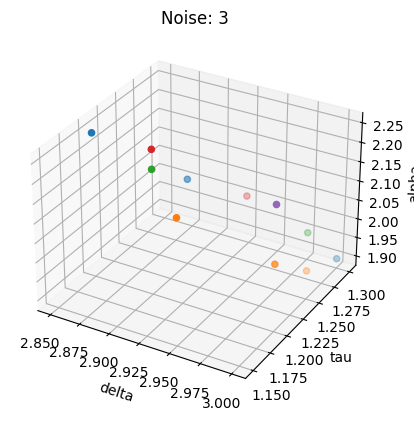

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

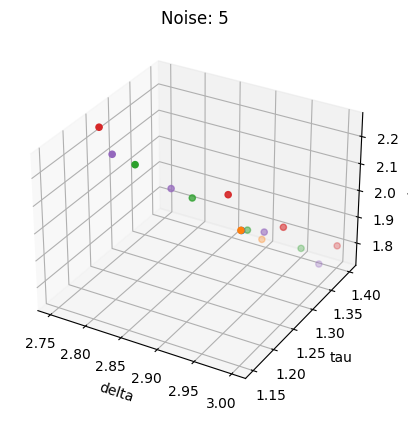

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

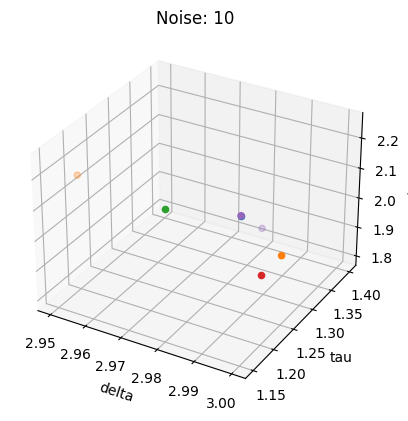

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration       cost  delta   tau  alpha
0         1        23   0.985167   2.80  1.20   2.25
1         1        73   0.969215   2.85  1.20   2.20
2         1         8   0.997571   2.85  1.20   2.25
3         1        29   0.956834   2.85  1.20   2.25
4         1        33   0.936942   2.85  1.20   2.25
...     ...       ...        ...    ...   ...    ...
2259     10        55  93.167720   3.00  1.40   1.75
2260     10        63  98.780056   3.00  1.40   1.85
2261     10        40  96.437531   3.00  1.40   1.90
2262     10        82  98.511070   3.00  1.40   2.05
2263     10        40  96.432247   3.00  1.45   1.80

[2264 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  2.90  0.577350  2.0  3.0  3.0  3.0  4.0
2                      100.0  2.74  0.848290  1.0  2.0  3.0  3.0  4.0
3                      100.0  2.75  0.891883  1.0  2.0  3.0  3.0  4.0
4                      100.0  2.42  1.084137  1.0  1.0  2.5  3.0  4.0
5                      100.0  2.08  0.939374  1.0  1.0  2.0  3.0  4.0
6                      100.0  2.28  1.054859  1.0  1.0  2.0  3.0  5.0
7                      100.0  1.92  1.060589  1.0  1.0  2.0  3.0  5.0
8                      100.0  1.83  0.910711  1.0  1.0  2.0  3.0  4.0
9                      100.0  1.91  1.101835  1.0  1.0  1.0  3.0  4.0
10                     100.0  1.81  1.051166  1.0  1.0  1.0  3.0  5.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration       cost  delta   tau  alpha
131       1         1   1.034875    3.0  1.20   2.10
132       1         2   0.998172    3.0  1.20   2.10
133       1         6   1.073742    3.0  1.20   2.10
134       1         9   1.010242    3.0  1.20   2.10
135       1        30   0.978243    3.0  1.20   2.10
...     ...       ...        ...    ...   ...    ...
2259     10        55  93.167720    3.0  1.40   1.75
2260     10        63  98.780056    3.0  1.40   1.85
2261     10        40  96.437531    3.0  1.40   1.90
2262     10        82  98.511070    3.0  1.40   2.05
2263     10        40  96.432247    3.0  1.45   1.80

[1207 rows x 6 columns]

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration       cost  delta   tau  alpha
2084     10        76  94.436468   2.05  1.75    2.0

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost  delta   tau  alpha
563       2        49    4.159824   3.00  1.40   1.75
699       3        35    9.238193   2.95  1.40   1.75
809       3        62    9.992105   3.00  1.35   1.75
834       3        31    9.411762   3.00  1.40   1.75
835       3        49    8.984310   3.00  1.40   1.75
...     ...       ...         ...    ...   ...    ...
2245     10         6   93.314806   3.00  1.30   1.75
2246     10        61   98.827218   3.00  1.30   1.75
2247     10        64  107.327699   3.00  1.30   1.75
2253     10        62   97.593533   3.00  1.35   1.75
2259     10        55   93.167720   3.00  1.40   1.75

[108 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
10       15      5  3.0000000000000018    6    15      6  1.3000000000000005   
2         1      1  3.0000000000000018    1     1      1  1.4000000000000006   
3         5      2  3.0000000000000018    4     5      2  1.4000000000000006   
4        12      4  3.0000000000000018    8    12      3  1.4000000000000006   
5        12      2  3.0000000000000018   11    12      3  1.3500000000000003   
6        12      4  3.0000000000000018    5    12      6  1.4000000000000006   
7        11      4  3.0000000000000018    7    11      6  1.4000000000000006   
8        19      6  3.0000000000000018    9    19      7  1.3500000000000003   
9        21      8  3.0000000000000018    8    21      8  1.4500000000000006   

            
      freq  
noise       
10       5  
2        1  
3        4  
4        7  
5        6  
6        4  
7        4  
8        5  
9        6

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost  delta   tau  alpha
0         1        23    0.985167   2.80  1.20   2.25
2         1         8    0.997571   2.85  1.20   2.25
3         1        29    0.956834   2.85  1.20   2.25
4         1        33    0.936942   2.85  1.20   2.25
5         1        35    1.033588   2.85  1.20   2.25
...     ...       ...         ...    ...   ...    ...
2228     10        67  103.047052   3.00  1.20   2.25
2241     10        27   98.456652   3.00  1.25   2.25
2242     10        52  117.420619   3.00  1.25   2.25
2243     10        72   99.855110   3.00  1.25   2.25
2244     10        90  109.373995   3.00  1.25   2.25

[480 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        23      4  2.8500000000000014    9    23      2  1.1500000000000004   
10       64     13  3.0000000000000018   36    64      8  1.1500000000000004   
2        34      6  2.9000000000000017   15    34      2  1.1500000000000004   
3        40      5  2.8000000000000016   13    40      4  1.2000000000000004   
4        46      8  2.9000000000000017   14    46      4  1.2000000000000004   
5        50      9  3.0000000000000018   22    50      5  1.1500000000000004   
6        55     10  3.0000000000000018   20    55      7  1.1500000000000004   
7        56     11  3.0000000000000018   23    56      7  1.1500000000000004   
8        57     10  3.0000000000000018   20    57      7  1.1500000000000004   
9        55     13  3.0000000000000018   24    55      7  1.2000000000000004   

            
      freq  
noise       
1       13  
10      17  
2       18  
3       20  
4       24  
5       19  
6       18  
7       17  
8       22  
9       14

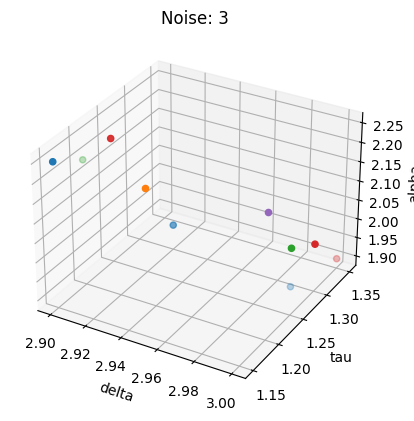

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

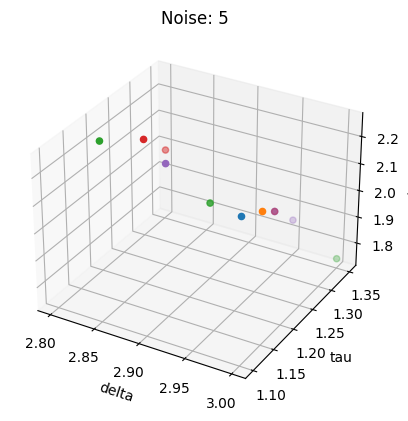

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

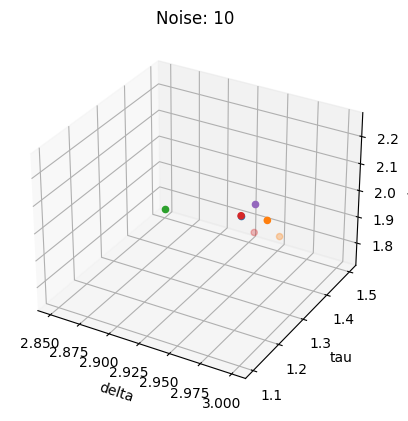

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()